In [1]:
from math import log2
from os import makedirs
import pandas as pd
from benchmarks.cli.data_loader import DEFAULT_DB_PATH, METHODS, TBL
import plotly.express as px
from IPython.display import Image
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.validators.scatter.marker import SymbolValidator
symbols = SymbolValidator().values[2::12]

In [2]:
db_path = DEFAULT_DB_PATH  # SQL db path to read epoch stats from
tbl = TBL                  # SQL table name to read epoch stats from
out_dir = None             # Directory to save plot PNG/JSON to (e.g. "m3", "azl")
host = None                # Description of host the stats were collected on, used in plot subtitle (e.g. "M3 Mac", "Amazon Linux")
show = None                # Set to "png" to render plots in notebook as PNGs (good for noninteractive mode / Git-committing)
hostname = None            # Filter DB "hostname" field to values matching this regex

In [3]:
# Parameters
out_dir = "azl"
show = "png"
hostname = "us-west-2"


In [4]:
db_uri = f'sqlite:///{db_path}'
df = pd.read_sql_table(tbl, db_uri)
if hostname:
    df = df[df.hostname.str.contains(hostname)].reset_index(drop=True)
df

,start,epoch,n_rows,elapsed,gc,max_mem,alb_start,sha,user,hostname,uri,method,batch_size,soma_chunk_size,py_buffer_size,soma_buffer_size
0,2024-06-03 20:26:10.506489,0,132766,60.005623,1.345223,1411547136,2024-06-03 20:26:10.374231,899ed0155a9b98d3b4bdc8b2ddf552e5e178efe1,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,1024,1073741824,1073741824
1,2024-06-03 20:27:11.728430,1,132766,59.918113,1.354261,1497325568,2024-06-03 20:26:10.374231,899ed0155a9b98d3b4bdc8b2ddf552e5e178efe1,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,1024,1073741824,1073741824
2,2024-06-03 20:28:12.604992,2,132766,60.673458,1.348365,1498841088,2024-06-03 20:26:10.374231,899ed0155a9b98d3b4bdc8b2ddf552e5e178efe1,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,1024,1073741824,1073741824
3,2024-06-03 20:29:14.348862,3,132766,60.790242,1.355865,1583144960,2024-06-03 20:26:10.374231,899ed0155a9b98d3b4bdc8b2ddf552e5e178efe1,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,1024,1073741824,1073741824
4,2024-06-03 20:30:16.145100,4,132766,61.312117,1.360942,1535852544,2024-06-03 20:26:10.374231,899ed0155a9b98d3b4bdc8b2ddf552e5e178efe1,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,1024,1073741824,1073741824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2024-06-04 22:09:52.242804,1,132766,43.798132,2.040425,7881453568,2024-06-04 22:09:00.517287,558176ed4f46842e6af60c940b2e1136cb6c42cb-dirty,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,32768,1073741824,1073741824
104,2024-06-04 22:10:44.197836,2,132766,43.707481,1.986737,6557323264,2024-06-04 22:09:00.517287,558176ed4f46842e6af60c940b2e1136cb6c42cb-dirty,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,32768,1073741824,1073741824
105,2024-06-04 22:11:35.996766,3,132766,41.157043,2.063893,7656337408,2024-06-04 22:09:00.517287,558176ed4f46842e6af60c940b2e1136cb6c42cb-dirty,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,32768,1073741824,1073741824
106,2024-06-04 22:12:27.761776,4,132766,44.062197,2.063199,6586019840,2024-06-04 22:09:00.517287,558176ed4f46842e6af60c940b2e1136cb6c42cb-dirty,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,32768,1073741824,1073741824


In [5]:
chunks_log2 = df.soma_chunk_size.apply(log2).apply(int).unique()
min_chunk_log2, max_chunk_log2 = chunks_log2.min(), chunks_log2.max()
chunks_log2 = chunks_log2.tolist()
min_chunk_log2, max_chunk_log2, chunks_log2

(10, 15, [10, 11, 12, 13, 14, 15])

In [6]:
chunk_sizes = list(map(str, sorted(df['soma_chunk_size'].unique())))
x = 'SOMA chunk size'
y = 'Samples / sec'
df[x] = pd.Categorical(df['soma_chunk_size'].apply(str), categories=chunk_sizes)
df[y] = df.n_rows / df.elapsed
df

,start,epoch,n_rows,elapsed,gc,max_mem,alb_start,sha,user,hostname,uri,method,batch_size,soma_chunk_size,py_buffer_size,soma_buffer_size,SOMA chunk size,Samples / sec
0,2024-06-03 20:26:10.506489,0,132766,60.005623,1.345223,1411547136,2024-06-03 20:26:10.374231,899ed0155a9b98d3b4bdc8b2ddf552e5e178efe1,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,1024,1073741824,1073741824,1024,2212.559327
1,2024-06-03 20:27:11.728430,1,132766,59.918113,1.354261,1497325568,2024-06-03 20:26:10.374231,899ed0155a9b98d3b4bdc8b2ddf552e5e178efe1,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,1024,1073741824,1073741824,1024,2215.790759
2,2024-06-03 20:28:12.604992,2,132766,60.673458,1.348365,1498841088,2024-06-03 20:26:10.374231,899ed0155a9b98d3b4bdc8b2ddf552e5e178efe1,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,1024,1073741824,1073741824,1024,2188.205587
3,2024-06-03 20:29:14.348862,3,132766,60.790242,1.355865,1583144960,2024-06-03 20:26:10.374231,899ed0155a9b98d3b4bdc8b2ddf552e5e178efe1,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,1024,1073741824,1073741824,1024,2184.001844
4,2024-06-03 20:30:16.145100,4,132766,61.312117,1.360942,1535852544,2024-06-03 20:26:10.374231,899ed0155a9b98d3b4bdc8b2ddf552e5e178efe1,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,np.array,1024,1024,1073741824,1073741824,1024,2165.412104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2024-06-04 22:09:52.242804,1,132766,43.798132,2.040425,7881453568,2024-06-04 22:09:00.517287,558176ed4f46842e6af60c940b2e1136cb6c42cb-dirty,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,32768,1073741824,1073741824,32768,3031.316516
104,2024-06-04 22:10:44.197836,2,132766,43.707481,1.986737,6557323264,2024-06-04 22:09:00.517287,558176ed4f46842e6af60c940b2e1136cb6c42cb-dirty,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,32768,1073741824,1073741824,32768,3037.603586
105,2024-06-04 22:11:35.996766,3,132766,41.157043,2.063893,7656337408,2024-06-04 22:09:00.517287,558176ed4f46842e6af60c940b2e1136cb6c42cb-dirty,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,32768,1073741824,1073741824,32768,3225.839174
106,2024-06-04 22:12:27.761776,4,132766,44.062197,2.063199,6586019840,2024-06-04 22:09:00.517287,558176ed4f46842e6af60c940b2e1136cb6c42cb-dirty,ec2-user,ip-172-31-0-157.us-west-2.compute.internal,data/census-benchmark_2:7,scipy.csr,1024,32768,1073741824,1073741824,32768,3013.149800


In [7]:
[hostname] = df.hostname.unique()
hostname

'ip-172-31-0-157.us-west-2.compute.internal'

In [8]:
[batch_size] = df.batch_size.unique()
batch_size

1024

In [9]:
if host is None:
    if 'm3.lan' in hostname:
        host = 'M3 Mac'
    elif 'us-west-2' in hostname:
        host = 'Amazon Linux'
host_str = f"{host}, " if host else ""

In [10]:
host_subtitle = f'({host_str}{batch_size} samples per PyTorch batch)'

In [11]:
def plot(
    fig,
    title,
    name=None,
    grid='#ccc',
    subtitle_size='0.8em',
    show=show,
    **kwargs,
):
    traces = {}
    if 'hovertemplate' in kwargs:
        traces['hovertemplate'] = kwargs.pop('hovertemplate')
    if 'w' in kwargs:
        kwargs['width'] = kwargs.pop('w')
    if 'h' in kwargs:
        kwargs['height'] = kwargs.pop('h')
    
    if isinstance(title, list):
        title, *subtitles = title
        prefix = f'<br><span style="font-size:{subtitle_size}">'
        suffix = '</span>'
        title = prefix.join([title] + [ f'{subtitle}{suffix}' for subtitle in subtitles ])

    fig = (
        fig
        .update_layout(
            plot_bgcolor='white',
            title=dict(text=title, x=0.5),
            **kwargs,
        ).update_traces(**traces)
        .update_xaxes(
            gridcolor=grid,
        ).update_yaxes(
            gridcolor=grid,
            zeroline=True,
            zerolinecolor=grid,
            zerolinewidth=1,
            rangemode='tozero',
        )
    )
    if out_dir and name:
        makedirs(out_dir, exist_ok=True)
        fig.write_image(f'{out_dir}/{name}.png', **dims)
        fig.write_json(f'{out_dir}/{name}.json')
    if show == 'png':
        return Image(fig.to_image(**dims))
    else:
        return fig

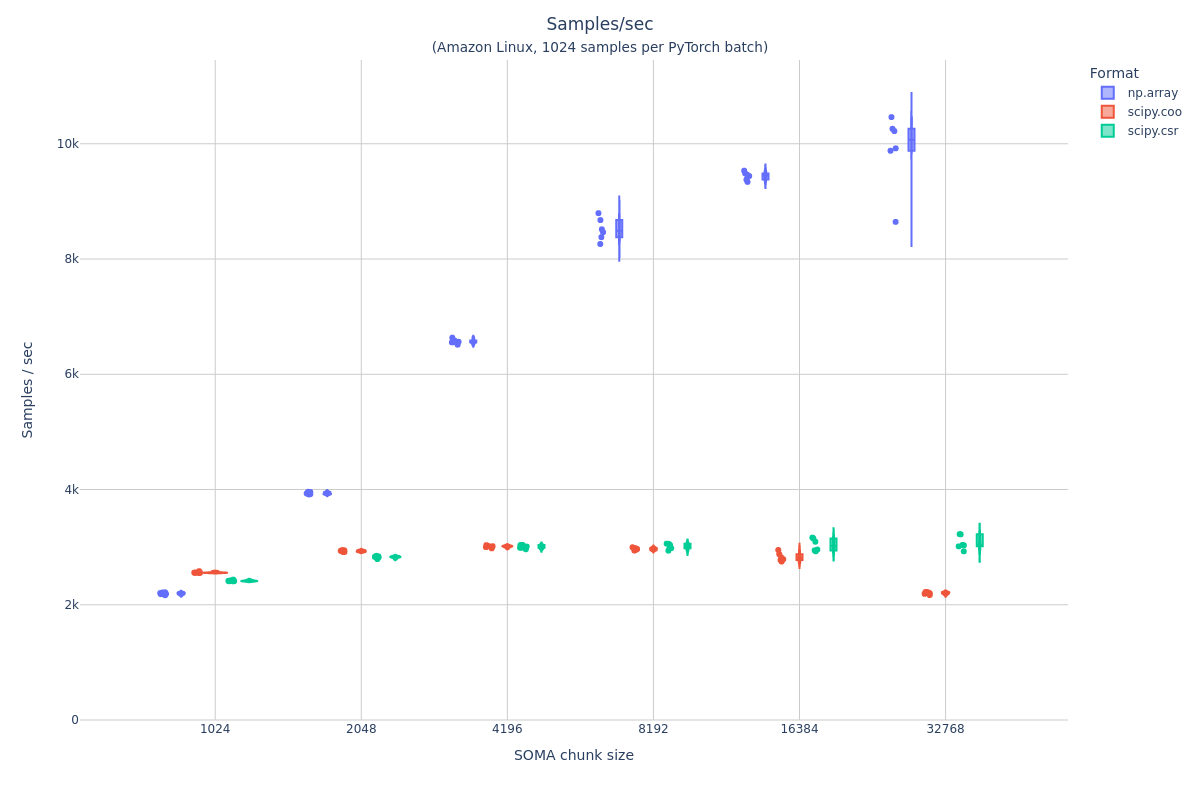

In [12]:
dims = dict(width=1200, height=800)
grid = '#ccc'
plot(
    px.violin(
        df, x=x, y=y,
        category_orders={ x: chunk_sizes, },
        color='method',
        box=True,
        points='all',
        labels={ 'method': "Format", }
    ),
    title=['Samples/sec', host_subtitle],
    name='speed_vs_chunks',
    **dims,
)

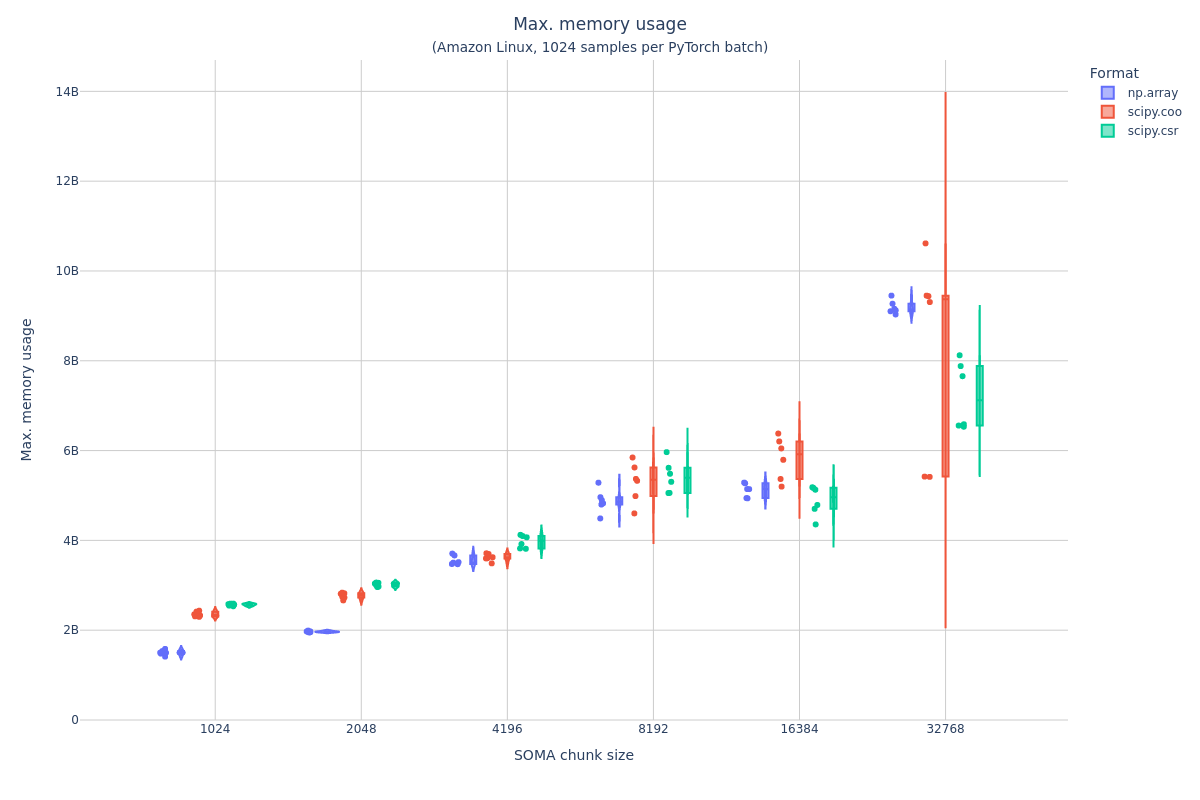

In [13]:
dims = dict(width=1200, height=800)
grid = '#ccc'
plot(
    px.violin(
        df, x=x, y='max_mem',
        category_orders={ x: chunk_sizes, },
        color='method',
        box=True,
        points='all',
        labels={ 'method': "Format", 'max_mem': 'Max. memory usage', }
    ),
    title=['Max. memory usage', host_subtitle],
    name="mem_vs_chunks",
    **dims,
)

In [14]:
title = "Samples/sec vs. memory use"

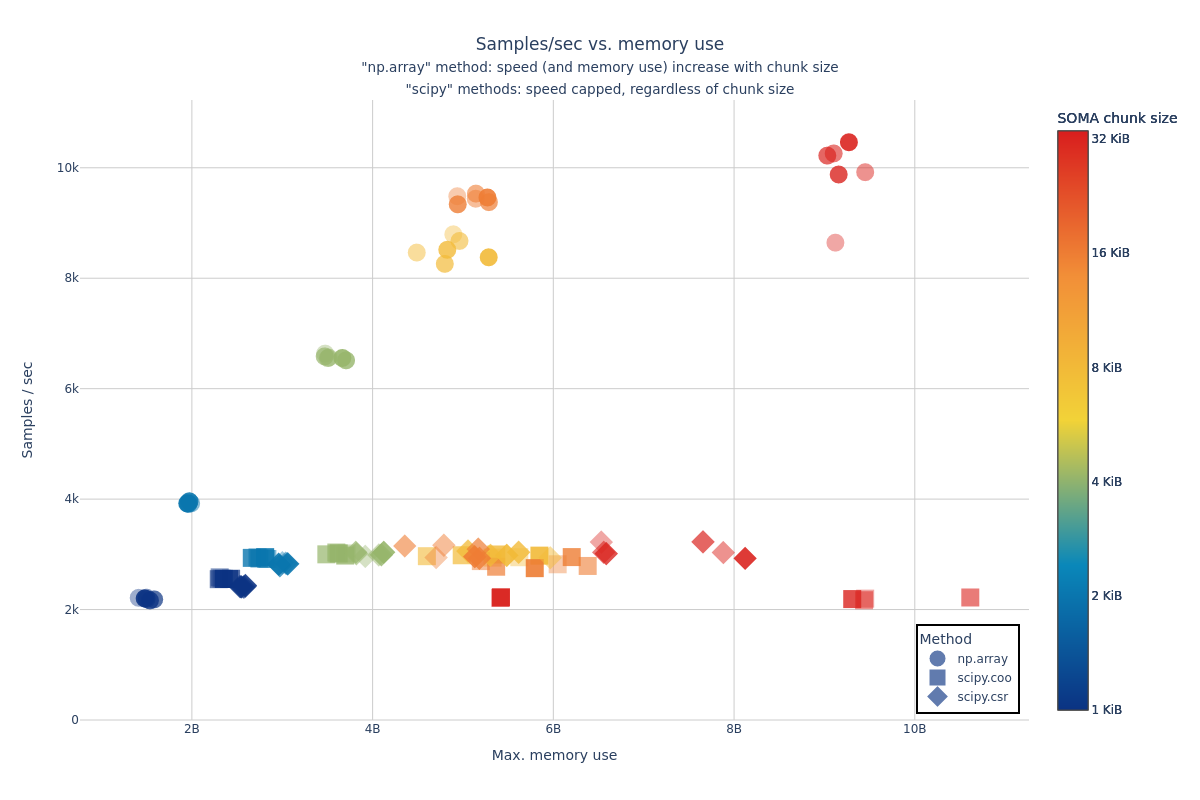

In [15]:
fig = go.Figure()
for idx, method in enumerate(METHODS):
    f = df[df.method == method]
    fig.add_trace(go.Scatter(
        name=method,
        x=f.max_mem,
        y=f[y],
        #text=f.epoch.astype(str),
        mode='markers+text',
        marker=dict(
            color=f.soma_chunk_size.apply(log2),
            colorscale=px.colors.diverging.Portland,
            #colorscale=px.colors.sequential.Bluered,
            #colorscale=px.colors.sequential.Burg,
            #colorscale=['green', 'red'],
            cmin=min_chunk_log2,
            cmax=max_chunk_log2 + .07,
            colorbar=dict(
                title='SOMA chunk size',
                tickmode='array',
                tickvals=chunks_log2,
                ticktext=list(map(lambda e: f'{2**(e-10)} KiB', chunks_log2)),
            ),
            showscale=True,
            opacity=0.4 + 0.5 * f.epoch / max(df.epoch),
            size=18,
            symbol=symbols[idx],
        ),
        customdata=f[['epoch', 'soma_chunk_size']],
    ))

plot(
    fig,
    [
        title,
        '"np.array" method: speed (and memory use) increase with chunk size',
        '"scipy" methods: speed capped, regardless of chunk size',
    ],
    name="speed_vs_mem_1",
    width=1000, height=600,
    hovertemplate='<br>'.join([
        "Epoch: %{customdata[0]}",
        "Samples/sec: %{y:,d}",
        "Memory: %{x:.3s}",
        "SOMA chunk size: %{customdata[1]}",
    ]),
    xaxis_title='Max. memory use',
    yaxis_title='Samples / sec',
    legend=dict(
        title_text='Method',
        xanchor='right', x=.99,
        yanchor='bottom', y=.01,
        bordercolor="Black",
        borderwidth=2,
    ),
)

In [16]:
max_mem = df.max_mem.max()
max_mem

10614202368

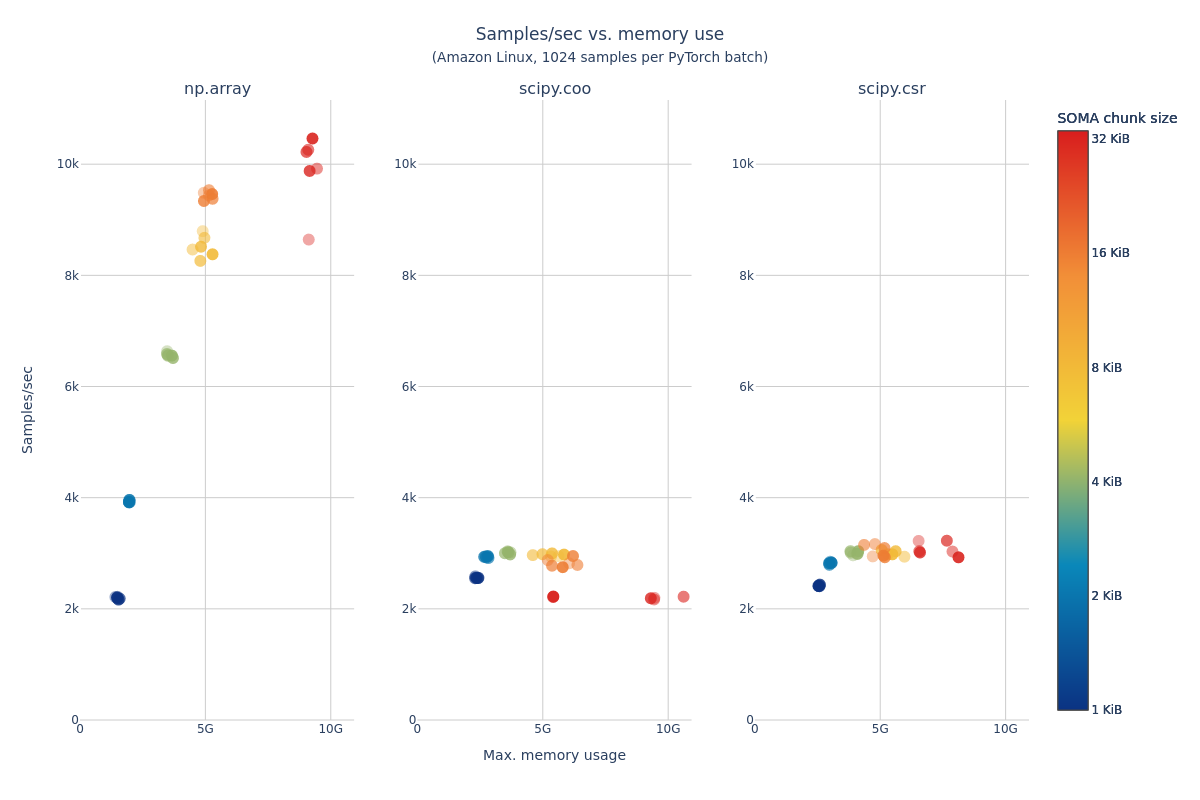

In [17]:
ncols = 3
fig = make_subplots(
    rows=1,
    cols=ncols,
    shared_yaxes=True,
    subplot_titles=METHODS,
)

for col, method in enumerate(METHODS):
    f = df[df.method == method]
    fig.add_trace(
        go.Scatter(
            x=f.max_mem,
            y=f[y],
            mode='markers',
            name=method,
            marker=dict(
                color=f.soma_chunk_size.apply(log2),
                colorscale=px.colors.diverging.Portland,
                cmin=min_chunk_log2,
                cmax=max_chunk_log2 + .07,
                colorbar=dict(
                    title='SOMA chunk size',
                    tickmode='array',
                    tickvals=chunks_log2,
                    ticktext=list(map(lambda e: f'{2**(e-10)} KiB', chunks_log2)),
                ),
                showscale=True,
                opacity=0.4 + 0.5 * f.epoch / max(df.epoch),
                size=12,
            ),
            customdata=f[['epoch', 'soma_chunk_size']],
        ),
        row=1, col=col+1,
    )

ss = [ "" if i == 1 else f"{i}" for i in range(1, ncols+1) ]
plot(
    fig.update_xaxes(range=[0, max_mem*1.03]),
    [ title, host_subtitle, ],
    title_y=.95,
    name="speed_vs_mem_3",
    width=1000, height=600,
    showlegend=False,
    **{ f"xaxis{(ncols+1)//2}_title": "Max. memory usage" },
    **{ f"xaxis{s}_tickformat": "s" for s in ss },
    yaxis_title="Samples/sec",
    **{ f"yaxis{s}_showticklabels": True for s in ss },
)